# Descarga de datos desde Postgres

In [52]:
!pip install psycopg2-binary sqlalchemy pandas matplotlib seaborn scikit-learn xgboost catboost


In [53]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
from sklearn.model_selection import train_test_split


In [54]:

pg_host = os.getenv("PG_HOST")
pg_port = os.getenv("PG_PORT")
pg_db = os.getenv("PG_DB")
pg_user = os.getenv("PG_USER")
pg_password = os.getenv("PG_PASSWORD")

engine = create_engine(
    f"postgresql://{pg_user}:{pg_password}@{pg_host}:{pg_port}/{pg_db}"
)

# 1. Definición del Problema de Negocio

**Objetivo:** Predecir la dirección del mercado para el día siguiente ($t+1$).

**Target (`target_up`):**
Es una variable binaria:
- `1`: Si el precio de cierre de mañana es MAYOR que el de hoy (Subida).
- `0`: Si el precio de cierre de mañana es MENOR o IGUAL al de hoy (Bajada).

$$
target\_up_{t} = \begin{cases} 
1 & \text{if } Close_{t+1} > Close_{t} \\
0 & \text{if } Close_{t+1} \leq Close_{t}
\end{cases}
$$

**Decisión que habilita:**
- Si el modelo predice `1`: **Comprar/Mantener (Long)** al cierre de hoy.
- Si el modelo predice `0`: **Vender/Short** o mantenerse en Cash.

# 2. Carga de datos 

In [55]:
df = pd.read_sql("SELECT * FROM analytics.prices_daily_features", engine)
# target_up (close > open)
df['target_up'] = (df['close'] > df['open']).astype(int)
print(f"Total filas en features: {len(df)}")
df.head()

Total filas en features: 5185


,date,ticker,open,high,low,close,volume,year,month,day_of_week,...,is_friday,is_earning_day,return_close_open,return_prev_close,volatility_7_days,volatility_30_days,close_lag1,ingested_at_utc,run_id,target_up
0,2020-01-21,NVDA,6.19525,6.23225,6.16425,6.19850,217916000,2020,1,21,...,0,0,0.000525,-0.005375,0.015913,0.014142,6.23200,2025-12-06 22:44:41.581579,NVDA-2020-2024,1
1,2020-01-22,NVDA,6.24400,6.33975,6.22500,6.25275,239240000,2020,1,22,...,0,0,0.001401,0.008752,0.016142,0.013730,6.19850,2025-12-06 22:44:41.581579,NVDA-2020-2024,1
2,2020-01-23,NVDA,6.29300,6.33000,6.20375,6.32150,244516000,2020,1,23,...,0,0,0.004529,0.010995,0.016276,0.013247,6.25275,2025-12-06 22:44:41.581579,NVDA-2020-2024,1
3,2020-01-24,NVDA,6.43750,6.48750,6.20750,6.26200,373512000,2020,1,24,...,1,0,-0.027262,-0.009412,0.011613,0.012893,6.32150,2025-12-06 22:44:41.581579,NVDA-2020-2024,0
4,2020-01-27,NVDA,5.95600,6.05625,5.80575,6.00500,470536000,2020,1,27,...,0,0,0.008227,-0.041041,0.009375,0.012887,6.26200,2025-12-06 22:44:41.581579,NVDA-2020-2024,1


# 3. EDA breve

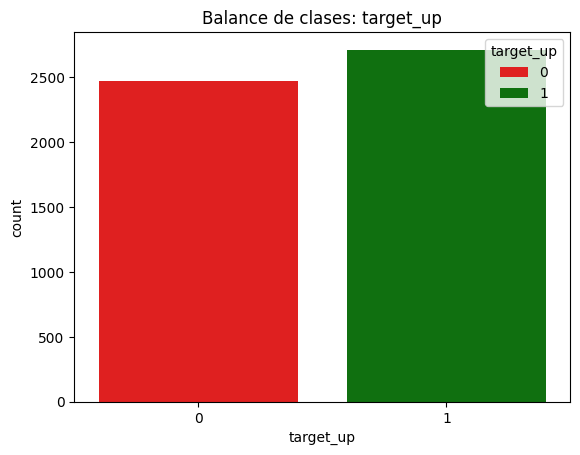

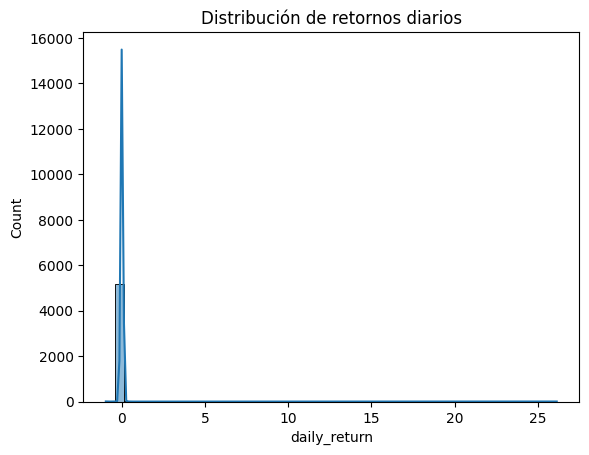

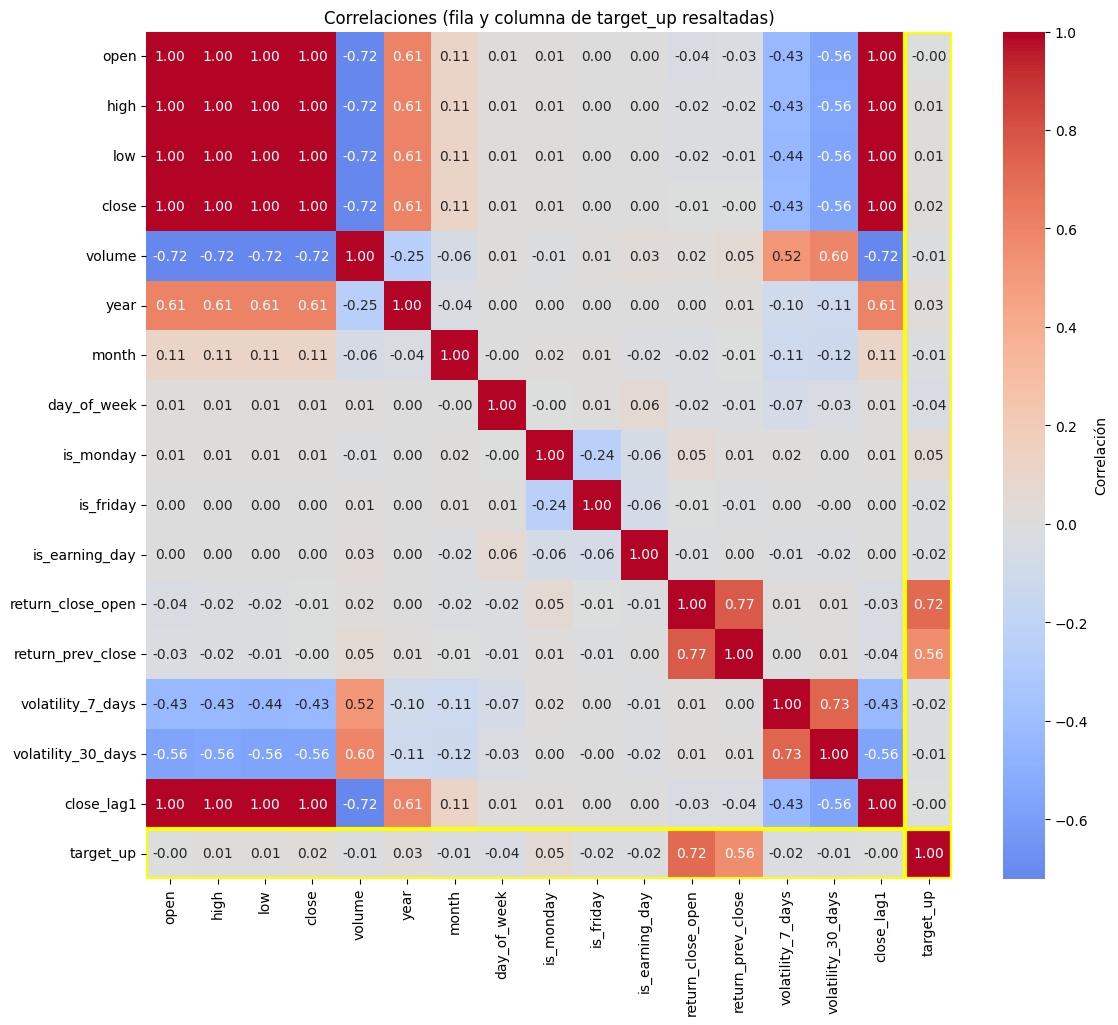

In [56]:
# EDA
# Balance de clases.
sns.countplot(x='target_up',hue='target_up', data=df, palette={1: 'green', 0: 'red'}) 
plt.title('Balance de clases: target_up')
plt.show()

# Distribucion de retornos diarios
df['daily_return'] = df['close'].pct_change() 
sns.histplot(df['daily_return'].dropna(), bins=50, kde=True)
plt.title('Distribución de retornos diarios')
plt.show()
# dropear daily_return para evitar confusión
df.drop(columns=['daily_return'], inplace=True)

# correlaciones simples (incluyendo sentimiento si aplica).

# quitar columnas no numéricas o irrelevantes
df_numeric = df.select_dtypes(include=[np.number])
corr = df_numeric.corr()
# crear matriz donde target_up tiene un borde grueso
corr = df.corr(numeric_only=True)

plt.figure(figsize=(13, 11))
ax = sns.heatmap(
    corr,
    annot=True,
    fmt=".2f",
    cmap='coolwarm',
    center=0,
    cbar_kws={"label": "Correlación"},
)

# sombrear fila + columna
idx = corr.columns.get_loc("target_up")

# sombrear fila
ax.add_patch(
    plt.Rectangle((0, idx), len(corr), 1, fill=False, edgecolor="yellow", lw=3)
)

# sombrear columna
ax.add_patch(
    plt.Rectangle((idx, 0), 1, len(corr), fill=False, edgecolor="yellow", lw=3)
)

plt.title("Correlaciones (fila y columna de target_up resaltadas)")
plt.show()


# Features y target

## Justificación
En series de tiempo financieras, solo podemos usar información que ya existe antes de la apertura del día que queremos predecir.
Por este motivo no usamos valores del mismo día como open, high, low, close o volume para predecir el mismo día:
esos datos aún no existirían al momento de tomar la decisión.
Se usa lags para:
- Evitar leakage (información del futuro)
- Capturar comportamiento reciente del mercado

In [57]:
# Seleccionar features y el target para ML
cols_to_lag = ['open', 'high', 'low', 'close', 'volume', 'return_prev_close', 'return_close_open']
for col in cols_to_lag:
    # crear columna lag 1 basada en ticker, 
    df[f'{col}_lag1'] = df.groupby('ticker')[col].shift(1)

feature_cols = ['open', 'open_lag1',
                'high_lag1', 'low_lag1', 'close_lag1',
                'volume_lag1', 'return_prev_close_lag1', 'return_close_open_lag1',
                'volatility_7_days', 'volatility_30_days', 'year', 'month', 'day_of_week',
                'is_monday', 'is_friday', 'is_earning_day', 'ticker']
target_col = 'target_up'

df['date'] = pd.to_datetime(df['date'])


# 5. Split temporal (Train / Val / Test)

In [58]:
# train  2021, 2022, 2023 validation 2024, test 2025
train_df = df[df['date'] < pd.to_datetime('2024-01-01')]
val_df = df[(df['date'] >= pd.to_datetime('2024-01-01')) & (df['date'] < pd.to_datetime('2025-01-01'))]
test_df = df[df['date'] >= pd.to_datetime('2025-01-01')]

X_train = train_df[feature_cols]
y_train = train_df[target_col]

X_val = val_df[feature_cols]
y_val = val_df[target_col]

X_test = test_df[feature_cols]
y_test = test_df[target_col]


# 6. Preprocesamiento

In [59]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer


# numerical features
categorical_features = ['is_monday', 'is_friday', 'is_earning_day', 'day_of_week', 'month', 'ticker']  # no tenemos features categóricas en este caso
numerical_features = [col for col in feature_cols if col not in categorical_features]
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')), # imputar valores faltantes con la media en numéricas
    ('scaler', StandardScaler()) # estandarizar
])

# One-hot encoder no es necesario porque las variables categóricas ya son binarias
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), # imputar valores faltantes con la moda en categóricas
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features),
    ]
)


# 7. Modelado

## 7.0 Baseline

In [60]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, roc_auc_score
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

Clase mayoritaria: 1
Logistic Regression - Validation Set
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       464
           1       0.54      1.00      0.70       544

    accuracy                           0.54      1008
   macro avg       0.27      0.50      0.35      1008
weighted avg       0.29      0.54      0.38      1008



/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


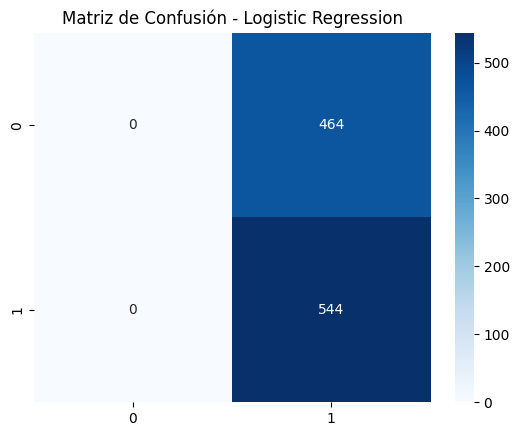

Baseline - Train Set
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1578
           1       0.52      1.00      0.68      1687

    accuracy                           0.52      3265
   macro avg       0.26      0.50      0.34      3265
weighted avg       0.27      0.52      0.35      3265



/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


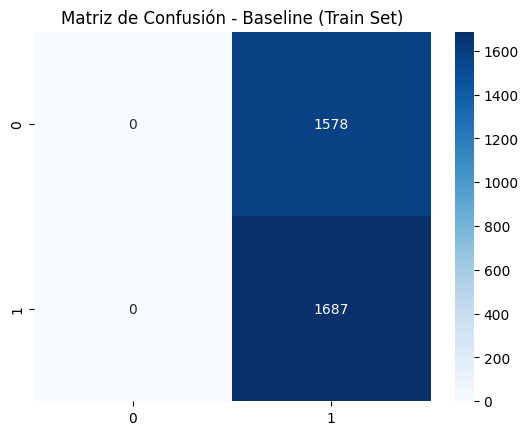

f1 Train Baseline: 0.6813
f1 Validation Baseline: 0.7010
roc_auc Train Baseline: 0.5000
roc_auc Validation Baseline: 0.5000
f1 Macro Train Baseline: 0.3407
f1 Macro Validation Baseline: 0.3505


In [61]:
# Crear un basline Modelo trivial: siempre predice la clase mayoritaria.

# Encontrar la clase mayoritaria en el conjunto de entrenamiento

majority_class = np.bincount(y_train).argmax()
print("Clase mayoritaria:", majority_class)

# Predecir siempre la clase mayoritaria
y_val_pred_baseline = np.full_like(y_val, fill_value=majority_class)

# Ver metricas del validation set
print("Logistic Regression - Validation Set")
print(classification_report(y_val, y_val_pred_baseline))
cm_logreg = confusion_matrix(y_val, y_val_pred_baseline)
sns.heatmap(cm_logreg, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión - Logistic Regression')
plt.show()

# Ver metricas del train set
y_train_pred_baseline = np.full_like(y_train, fill_value=majority_class)
print("Baseline - Train Set")
print(classification_report(y_train, y_train_pred_baseline))
cm_train_baseline = confusion_matrix(y_train, y_train_pred_baseline)
sns.heatmap(cm_train_baseline, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión - Baseline (Train Set)')
plt.show()

# f1-score, roc_auc, f1-score-macro
f1_train_baseline = f1_score(y_train, y_train_pred_baseline)
f1_val_baseline = f1_score(y_val, y_val_pred_baseline)
roc_auc_train_baseline = roc_auc_score(y_train, y_train_pred_baseline)
roc_auc_val_baseline = roc_auc_score(y_val, y_val_pred_baseline)
f1_macro_train_baseline = f1_score(y_train, y_train_pred_baseline, average='macro')
f1_macro_val_baseline = f1_score(y_val, y_val_pred_baseline, average='macro')
print(f"f1 Train Baseline: {f1_train_baseline:.4f}")
print(f"f1 Validation Baseline: {f1_val_baseline:.4f}")
print(f"roc_auc Train Baseline: {roc_auc_train_baseline:.4f}")
print(f"roc_auc Validation Baseline: {roc_auc_val_baseline:.4f}")
print(f"f1 Macro Train Baseline: {f1_macro_train_baseline:.4f}")
print(f"f1 Macro Validation Baseline: {f1_macro_val_baseline:.4f}")





## 7.1 Lineales
### 7.1.1 Logistic Regression

In [62]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV

# Crear pipeline completo
pipeline_logreg = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', LogisticRegression(max_iter=1000))])
# Hiperparámetros para GridSearch
param_grid = {
    'classifier__C': [0.01, 0.1, 1, 10], # regularización
    'classifier__penalty': ['l2', 'l1', 'elasticnet'], # tipo de penalización
    'classifier__solver': ['saga'], # saga soporta l1 y elasticnet
    'classifier__class_weight': [None, 'balanced'], # manejar desequilibrio de clases
    'classifier__l1_ratio': [0, 0.3, 0.5, 0.8, 1], # solo usado si penalty es 'elasticnet'
    'classifier__max_iter': [1000, 3000, 5000]
}
print("Buscando mejores hiperparametros para Logistic Regression")
grid_search_logreg = GridSearchCV(pipeline_logreg, param_grid, cv=tscv, scoring='roc_auc', n_jobs=-1)
grid_search_logreg.fit(X_train, y_train)
best_logreg = grid_search_logreg.best_estimator_
y_val_pred_logreg = best_logreg.predict(X_val)
print("Mejores hiperparametros Logistic Regression:", grid_search_logreg.best_params_)


Buscando mejores hiperparametros para Logistic Regression


/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_

Mejores hiperparametros Logistic Regression: {'classifier__C': 1, 'classifier__class_weight': None, 'classifier__l1_ratio': 0.5, 'classifier__max_iter': 3000, 'classifier__penalty': 'elasticnet', 'classifier__solver': 'saga'}


Logistic Regression - Validation Set
              precision    recall  f1-score   support

           0       0.47      0.41      0.44       464
           1       0.55      0.61      0.58       544

    accuracy                           0.52      1008
   macro avg       0.51      0.51      0.51      1008
weighted avg       0.51      0.52      0.51      1008



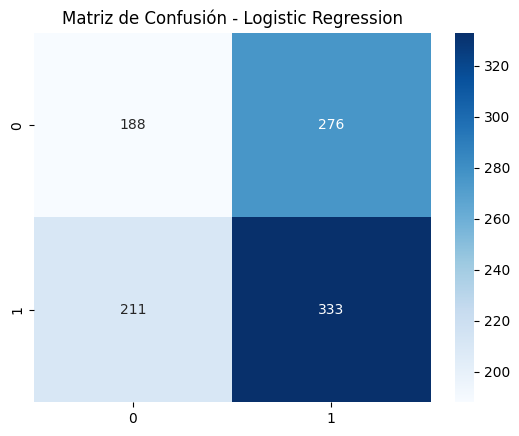

Logistic Regression - Train Set
              precision    recall  f1-score   support

           0       0.59      0.50      0.54      1578
           1       0.59      0.67      0.63      1687

    accuracy                           0.59      3265
   macro avg       0.59      0.58      0.58      3265
weighted avg       0.59      0.59      0.58      3265



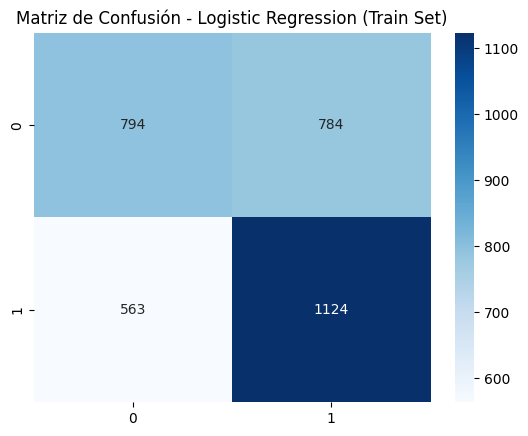

F1-Score Train Logistic Regression: 0.6253
F1-Score Validation Logistic Regression: 0.5776
ROC AUC Train Logistic Regression: 0.5847
ROC AUC Validation Logistic Regression: 0.5087
F1-Macro-Score Train Logistic Regression: 0.5832
F1-Macro-Score Validation Logistic Regression: 0.5067


In [63]:

# Ver metricas del validation set
print("Logistic Regression - Validation Set")
print(classification_report(y_val, y_val_pred_logreg))
cm_logreg = confusion_matrix(y_val, y_val_pred_logreg)
sns.heatmap(cm_logreg, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión - Logistic Regression')
plt.show()

# Ver metricas del train set
y_train_pred_logreg = best_logreg.predict(X_train)
print("Logistic Regression - Train Set")
print(classification_report(y_train, y_train_pred_logreg))
cm_train_logreg = confusion_matrix(y_train, y_train_pred_logreg)
sns.heatmap(cm_train_logreg, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión - Logistic Regression (Train Set)')
plt.show()

# f1-score, roc_auc, f1-score-macro
f1_train_logreg = f1_score(y_train, y_train_pred_logreg)
f1_val_logreg = f1_score(y_val, y_val_pred_logreg)
roc_auc_train_logreg = roc_auc_score(y_train, y_train_pred_logreg)
roc_auc_val_logreg = roc_auc_score(y_val, y_val_pred_logreg)
f1_macro_train_logreg = f1_score(y_train, y_train_pred_logreg, average='macro')
f1_macro_val_logreg = f1_score(y_val, y_val_pred_logreg, average='macro')

print(f"F1-Score Train Logistic Regression: {f1_train_logreg:.4f}")
print(f"F1-Score Validation Logistic Regression: {f1_val_logreg:.4f}")
print(f"ROC AUC Train Logistic Regression: {roc_auc_train_logreg:.4f}")
print(f"ROC AUC Validation Logistic Regression: {roc_auc_val_logreg:.4f}")
print(f"F1-Macro-Score Train Logistic Regression: {f1_macro_train_logreg:.4f}")
print(f"F1-Macro-Score Validation Logistic Regression: {f1_macro_val_logreg:.4f}")

## 7.2 Arbol de decisión
###  7.2.1 Decision Tree Classifier

In [64]:
# Decision Tree Classifier
from sklearn.tree import DecisionTreeClassifier

# Create pipeline completo
pipeline_dt = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', DecisionTreeClassifier())])
param_grid_dt = {
    'classifier__max_depth': [5, 10, 15, 20, None],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__class_weight': [None, 'balanced']
}
print("Buscando mejores hiperparametros para Decision Tree")
grid_search_dt = GridSearchCV(pipeline_dt, param_grid_dt, cv=tscv, scoring='roc_auc', n_jobs=-1)
grid_search_dt.fit(X_train, y_train)
best_dt = grid_search_dt.best_estimator_
y_val_pred_dt = best_dt.predict(X_val)
print("Mejores hiperparametros Decision Tree:", grid_search_dt.best_params_)
hiperparams_dt = grid_search_dt.best_params_


Buscando mejores hiperparametros para Decision Tree
Mejores hiperparametros Decision Tree: {'classifier__class_weight': 'balanced', 'classifier__max_depth': 10, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2}


Decision Tree Classifier - Validation Set
              precision    recall  f1-score   support

           0       0.46      0.50      0.48       464
           1       0.54      0.51      0.53       544

    accuracy                           0.50      1008
   macro avg       0.50      0.50      0.50      1008
weighted avg       0.51      0.50      0.51      1008



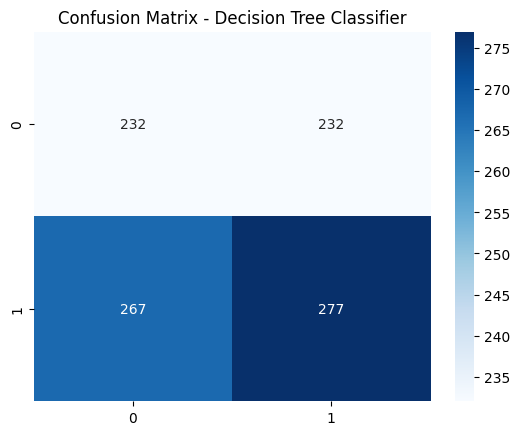

Decision Tree Classifier - Train Set
              precision    recall  f1-score   support

           0       0.61      0.71      0.66      1578
           1       0.68      0.58      0.63      1687

    accuracy                           0.64      3265
   macro avg       0.65      0.65      0.64      3265
weighted avg       0.65      0.64      0.64      3265



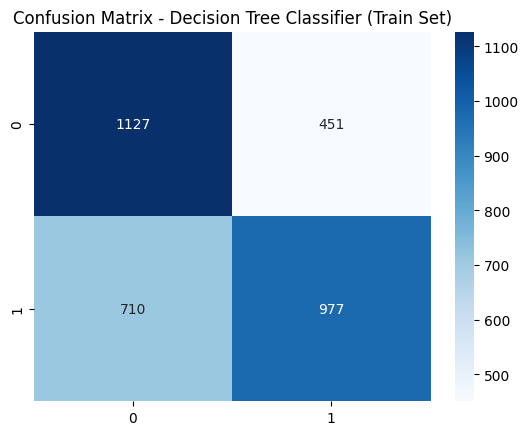

F1-Score Train Decision Tree: 0.6273
F1-Score Validation Decision Tree: 0.5261
ROC AUC Train Decision Tree: 0.6467
ROC AUC Validation Decision Tree: 0.5046
F1-Macro-Score Train Decision Tree: 0.6437
F1-Macro-Score Validation Decision Tree: 0.5040


In [65]:

# Ver metricas del validation set
print("Decision Tree Classifier - Validation Set")
print(classification_report(y_val, y_val_pred_dt))
cm_dt = confusion_matrix(y_val, y_val_pred_dt)
sns.heatmap(cm_dt, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Decision Tree Classifier")
plt.show()

# Ver metricas del train set
y_train_pred_dt = best_dt.predict(X_train)
print("Decision Tree Classifier - Train Set")
print(classification_report(y_train, y_train_pred_dt))
cm_train_dt = confusion_matrix(y_train, y_train_pred_dt)
sns.heatmap(cm_train_dt, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Decision Tree Classifier (Train Set)")
plt.show()

# f1-score, roc_auc, f1-score-macro
f1_train_dt = f1_score(y_train, y_train_pred_dt)
f1_val_dt = f1_score(y_val, y_val_pred_dt)
roc_auc_train_dt = roc_auc_score(y_train, y_train_pred_dt)
roc_auc_val_dt = roc_auc_score(y_val, y_val_pred_dt)
f1_macro_train_dt = f1_score(y_train, y_train_pred_dt, average='macro')
f1_macro_val_dt = f1_score(y_val, y_val_pred_dt, average='macro')
print(f"F1-Score Train Decision Tree: {f1_train_dt:.4f}")
print(f"F1-Score Validation Decision Tree: {f1_val_dt:.4f}")
print(f"ROC AUC Train Decision Tree: {roc_auc_train_dt:.4f}")
print(f"ROC AUC Validation Decision Tree: {roc_auc_val_dt:.4f}")
print(f"F1-Macro-Score Train Decision Tree: {f1_macro_train_dt:.4f}")
print(f"F1-Macro-Score Validation Decision Tree: {f1_macro_val_dt:.4f}")


## 7.3 Random Forest
### 7.3.1 Random Forest Classifier

In [66]:
# random forest classifier
from sklearn.ensemble import RandomForestClassifier
# Create pipeline completo
pipeline_rf = Pipeline(steps=[('preprocessor', preprocessor),
                             ('classifier', RandomForestClassifier())])

param_grid_rf = {
    'classifier__n_estimators': [50, 100, 150],
    'classifier__max_depth': [3, 5, 7, 10],
    'classifier__min_samples_split': [10, 20, 40],
    'classifier__min_samples_leaf': [10, 15, 20],
    'classifier__max_features': ['sqrt', 'log2', 0.5], 
    'classifier__criterion': ['gini', 'entropy']
}

print("Buscando mejores hiperparametros para Random Forest")
grid_search_rf = GridSearchCV(pipeline_rf, param_grid_rf, cv=tscv, scoring='roc_auc', n_jobs=-1)
grid_search_rf.fit(X_train, y_train)
best_rf = grid_search_rf.best_estimator_
y_val_pred_rf = best_rf.predict(X_val)
print("Mejores hiperparametros Random Forest:", grid_search_rf.best_params_)
hiperparams_rf = grid_search_rf.best_params_


Buscando mejores hiperparametros para Random Forest
Mejores hiperparametros Random Forest: {'classifier__criterion': 'gini', 'classifier__max_depth': 7, 'classifier__max_features': 'log2', 'classifier__min_samples_leaf': 15, 'classifier__min_samples_split': 40, 'classifier__n_estimators': 100}


Random Forest Classifier - Validation Set
              precision    recall  f1-score   support

           0       0.51      0.45      0.48       464
           1       0.57      0.64      0.60       544

    accuracy                           0.55      1008
   macro avg       0.54      0.54      0.54      1008
weighted avg       0.54      0.55      0.54      1008



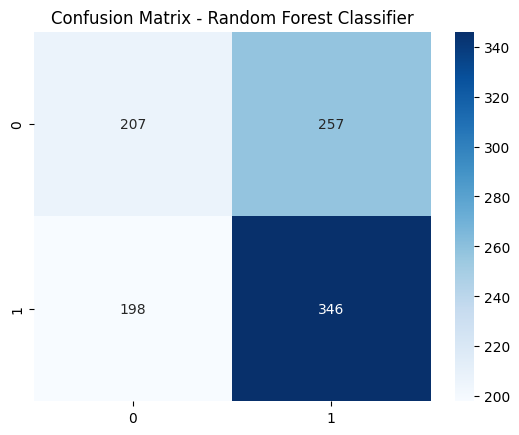

Random Forest Classifier - Train Set
              precision    recall  f1-score   support

           0       0.74      0.52      0.61      1578
           1       0.65      0.83      0.73      1687

    accuracy                           0.68      3265
   macro avg       0.69      0.67      0.67      3265
weighted avg       0.69      0.68      0.67      3265



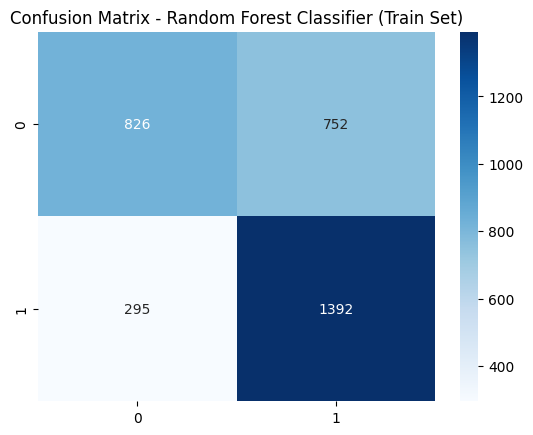

F1-Score Train Random Forest: 0.7267
F1-Score Validation Random Forest: 0.6033
ROC AUC Train Random Forest: 0.6743
ROC AUC Validation Random Forest: 0.5411
F1-Macro-Score Train Random Forest: 0.6694
F1-Macro-Score Validation Random Forest: 0.5399


In [67]:

# Ver metricas del validation set
print("Random Forest Classifier - Validation Set")
print(classification_report(y_val, y_val_pred_rf))
cm_rf = confusion_matrix(y_val, y_val_pred_rf)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Random Forest Classifier")
plt.show()

# Ver metricas del train set
y_train_pred_rf = best_rf.predict(X_train)
print("Random Forest Classifier - Train Set")
print(classification_report(y_train, y_train_pred_rf))
cm_train_rf = confusion_matrix(y_train, y_train_pred_rf)
sns.heatmap(cm_train_rf, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Random Forest Classifier (Train Set)")
plt.show()

# f1-score, roc_auc, f1-score-macro
f1_train_rf = f1_score(y_train, y_train_pred_rf)
f1_val_rf = f1_score(y_val, y_val_pred_rf)
roc_auc_train_rf = roc_auc_score(y_train, y_train_pred_rf)
roc_auc_val_rf = roc_auc_score(y_val, y_val_pred_rf)
f1_macro_train_rf = f1_score(y_train, y_train_pred_rf, average='macro')
f1_macro_val_rf = f1_score(y_val, y_val_pred_rf, average='macro')
print(f"F1-Score Train Random Forest: {f1_train_rf:.4f}")
print(f"F1-Score Validation Random Forest: {f1_val_rf:.4f}")
print(f"ROC AUC Train Random Forest: {roc_auc_train_rf:.4f}")
print(f"ROC AUC Validation Random Forest: {roc_auc_val_rf:.4f}")
print(f"F1-Macro-Score Train Random Forest: {f1_macro_train_rf:.4f}")
print(f"F1-Macro-Score Validation Random Forest: {f1_macro_val_rf:.4f}")

### 7.3.2 Extra Tree Classifier

Buscando mejores hiperparametros para Extra Trees
Mejores hiperparametros Extra Trees: {'classifier__class_weight': 'balanced', 'classifier__max_depth': 20, 'classifier__max_features': 'sqrt', 'classifier__min_samples_leaf': 5, 'classifier__min_samples_split': 30, 'classifier__n_estimators': 100}
Extra Trees Classifier - Validation Set
              precision    recall  f1-score   support

           0       0.45      0.46      0.45       464
           1       0.53      0.52      0.53       544

    accuracy                           0.49      1008
   macro avg       0.49      0.49      0.49      1008
weighted avg       0.49      0.49      0.49      1008



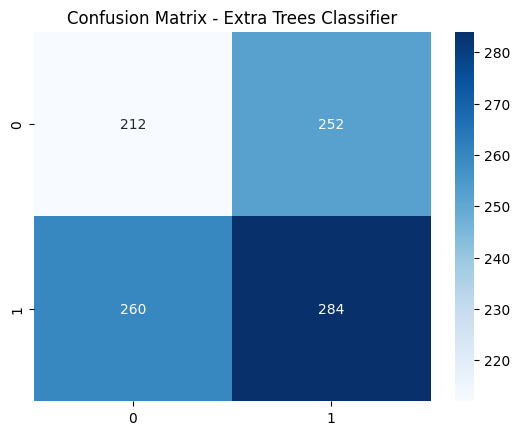

Extra Trees Classifier - Train Set
              precision    recall  f1-score   support

           0       0.77      0.77      0.77      1578
           1       0.79      0.78      0.79      1687

    accuracy                           0.78      3265
   macro avg       0.78      0.78      0.78      3265
weighted avg       0.78      0.78      0.78      3265



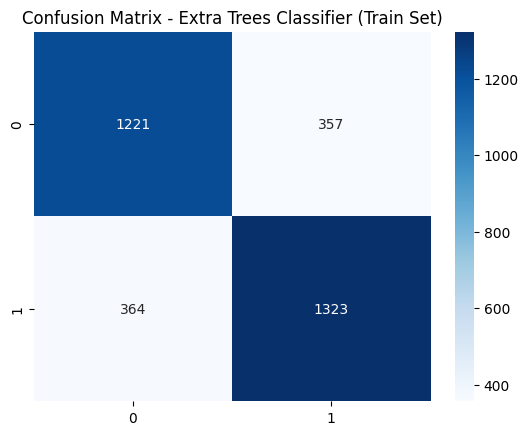

F1-Score Train Extra Trees: 0.7859
F1-Score Validation Extra Trees: 0.5259
ROC AUC Train Extra Trees: 0.7790
ROC AUC Validation Extra Trees: 0.4895
F1-Macro-Score Train Extra Trees: 0.7790
F1-Macro-Score Validation Extra Trees: 0.4895


In [68]:
# Extra Trees Classifier
from sklearn.ensemble import ExtraTreesClassifier
# Create pipeline completo
pipeline_et = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', ExtraTreesClassifier())])
param_grid_et = {
    'classifier__n_estimators': [50, 100, 150],
    'classifier__max_depth': [10, 15, 20],
    'classifier__min_samples_split': [5, 15, 30],
    'classifier__min_samples_leaf': [5, 10, 20],
    'classifier__class_weight': [None, 'balanced'],
    'classifier__max_features': ['sqrt', 'log2', 0.5],
}
print("Buscando mejores hiperparametros para Extra Trees")
grid_search_et = GridSearchCV(pipeline_et, param_grid_et, cv=tscv, scoring='roc_auc', n_jobs=-1)
grid_search_et.fit(X_train, y_train)
best_et = grid_search_et.best_estimator_
y_val_pred_et = best_et.predict(X_val)
print("Mejores hiperparametros Extra Trees:", grid_search_et.best_params_)
hiperparams_et = grid_search_et.best_params_

# Ver metricas del validation set
print("Extra Trees Classifier - Validation Set")
print(classification_report(y_val, y_val_pred_et))
cm_et = confusion_matrix(y_val, y_val_pred_et)
sns.heatmap(cm_et, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Extra Trees Classifier")
plt.show()
# Ver metricas del train set
y_train_pred_et = best_et.predict(X_train)
print("Extra Trees Classifier - Train Set")
print(classification_report(y_train, y_train_pred_et))
cm_train_et = confusion_matrix(y_train, y_train_pred_et)
sns.heatmap(cm_train_et, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Extra Trees Classifier (Train Set)")
plt.show()

#f1-score
f1_train_et = f1_score(y_train, y_train_pred_et)
f1_val_et = f1_score(y_val, y_val_pred_et)
roc_auc_train_et = roc_auc_score(y_train, y_train_pred_et)
roc_auc_val_et = roc_auc_score(y_val, y_val_pred_et)
f1_macro_train_et = f1_score(y_train, y_train_pred_et, average='macro')
f1_macro_val_et = f1_score(y_val, y_val_pred_et, average='macro')
print(f"F1-Score Train Extra Trees: {f1_train_et:.4f}")
print(f"F1-Score Validation Extra Trees: {f1_val_et:.4f}")
print(f"ROC AUC Train Extra Trees: {roc_auc_train_et:.4f}")
print(f"ROC AUC Validation Extra Trees: {roc_auc_val_et:.4f}")
print(f"F1-Macro-Score Train Extra Trees: {f1_macro_train_et:.4f}")
print(f"F1-Macro-Score Validation Extra Trees: {f1_macro_val_et:.4f}")

## 7.4 Boosting
### 7.4.1 Gradient Boosting

In [84]:
# Gradient Boosting Classifier
from sklearn.ensemble import GradientBoostingClassifier
# Create pipeline completo
pipeline_gb = Pipeline(steps=[('preprocessor', preprocessor),
                             ('classifier', GradientBoostingClassifier())])

# Eliminar overfitting
param_grid_gb = {
    'classifier__n_estimators': [50, 70, 100], 
    'classifier__learning_rate': [0.1, 0.2, 0.3],
    'classifier__max_depth': [3],
    'classifier__loss': ['log_loss', 'exponential'],
    'classifier__subsample': [0.5, 0.75],
    'classifier__max_features': ['sqrt', 'log2'],
    'classifier__min_samples_split': [20, 25]
}
print("Buscando mejores hiperparametros para Gradient Boosting")
grid_search_gb = GridSearchCV(pipeline_gb, param_grid_gb, cv=tscv, scoring='roc_auc', n_jobs=-1)
grid_search_gb.fit(X_train, y_train)
best_gb = grid_search_gb.best_estimator_
hiperparams_gb = grid_search_gb.best_params_

y_val_pred_gb = best_gb.predict(X_val)
print("Mejores hiperparametros Gradient Boosting:", grid_search_gb.best_params_)


Buscando mejores hiperparametros para Gradient Boosting
Mejores hiperparametros Gradient Boosting: {'classifier__learning_rate': 0.3, 'classifier__loss': 'exponential', 'classifier__max_depth': 3, 'classifier__max_features': 'log2', 'classifier__min_samples_split': 25, 'classifier__n_estimators': 100, 'classifier__subsample': 0.5}


Gradient Boosting Classifier - Validation Set
              precision    recall  f1-score   support

           0       0.47      0.71      0.56       464
           1       0.56      0.32      0.40       544

    accuracy                           0.50      1008
   macro avg       0.51      0.51      0.48      1008
weighted avg       0.52      0.50      0.48      1008



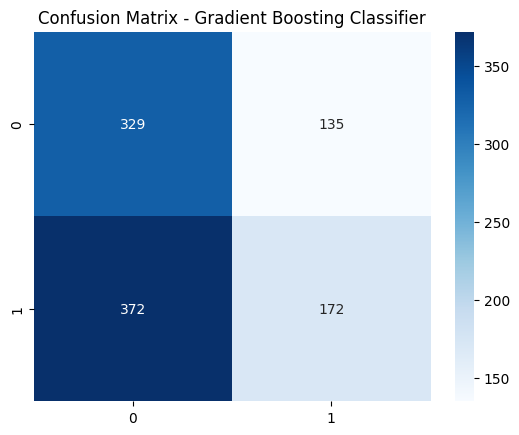

Gradient Boosting Classifier - Train Set
              precision    recall  f1-score   support

           0       0.70      0.67      0.68      1578
           1       0.70      0.73      0.71      1687

    accuracy                           0.70      3265
   macro avg       0.70      0.70      0.70      3265
weighted avg       0.70      0.70      0.70      3265



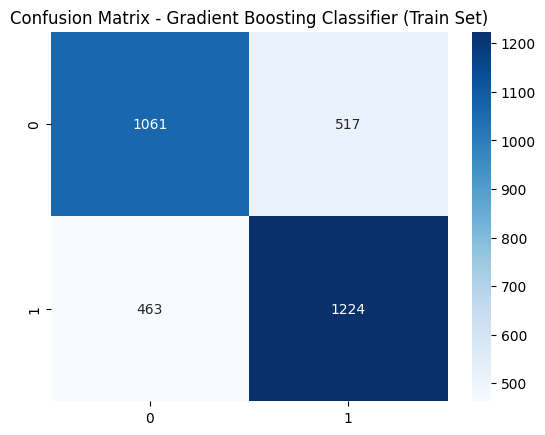

F1-Score Train Gradient Boosting: 0.7141
F1-Score Validation Gradient Boosting: 0.4042
ROC AUC Train Gradient Boosting: 0.6990
ROC AUC Validation Gradient Boosting: 0.5126
F1-Macro-Score Train Gradient Boosting: 0.6991
F1-Macro-Score Validation Gradient Boosting: 0.4845


In [85]:

# Ver metricas del validation set
print("Gradient Boosting Classifier - Validation Set")
print(classification_report(y_val, y_val_pred_gb))
cm_gb = confusion_matrix(y_val, y_val_pred_gb)
sns.heatmap(cm_gb, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Gradient Boosting Classifier")
plt.show()

# Ver metricas del train set
y_train_pred_gb = best_gb.predict(X_train)
print("Gradient Boosting Classifier - Train Set")
print(classification_report(y_train, y_train_pred_gb))
cm_train_gb = confusion_matrix(y_train, y_train_pred_gb)
sns.heatmap(cm_train_gb, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Gradient Boosting Classifier (Train Set)")
plt.show()

# f1-score, roc_auc, f1-score-macro
f1_train_gb = f1_score(y_train, y_train_pred_gb)
f1_val_gb = f1_score(y_val, y_val_pred_gb)
roc_auc_train_gb = roc_auc_score(y_train, y_train_pred_gb)
roc_auc_val_gb = roc_auc_score(y_val, y_val_pred_gb)
f1_macro_train_gb = f1_score(y_train, y_train_pred_gb, average='macro')
f1_macro_val_gb = f1_score(y_val, y_val_pred_gb, average='macro')
print(f"F1-Score Train Gradient Boosting: {f1_train_gb:.4f}")
print(f"F1-Score Validation Gradient Boosting: {f1_val_gb:.4f}")
print(f"ROC AUC Train Gradient Boosting: {roc_auc_train_gb:.4f}")
print(f"ROC AUC Validation Gradient Boosting: {roc_auc_val_gb:.4f}")
print(f"F1-Macro-Score Train Gradient Boosting: {f1_macro_train_gb:.4f}")
print(f"F1-Macro-Score Validation Gradient Boosting: {f1_macro_val_gb:.4f}")


### 7.4.2 XGBoost

In [83]:
# XGBoost Classifier
from xgboost import XGBClassifier

# Create pipeline completo
pipeline_xgb = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', XGBClassifier())])
param_grid_xgb = {
    'classifier__n_estimators': [80, 200],  # menos árboles
    'classifier__learning_rate': [0.01, 0.05, 0.1],  # más conservador
    'classifier__max_depth': [2, 3],  # árboles menos profundos
    'classifier__reg_lambda': [0.5, 1, 2],  # más regularización L2
    'classifier__reg_alpha': [0.5, 1, 2],  # más regularización L1
    'classifier__subsample': [0.5, 0.8],  # controlar overfitting
    'classifier__colsample_bytree': [0.5, 0.8]  # controlar overfitting en columnas
}

print("Buscando mejores hiperparametros para XGBoost")
grid_search_xgb = GridSearchCV(pipeline_xgb, param_grid_xgb, cv=tscv, scoring='roc_auc', n_jobs=-1)
grid_search_xgb.fit(X_train, y_train)
best_xgb = grid_search_xgb.best_estimator_
y_val_pred_xgb = best_xgb.predict(X_val)
print("Mejores hiperparametros XGBoost:", grid_search_xgb.best_params_)
hiperparams_xgb = grid_search_xgb.best_params_


Buscando mejores hiperparametros para XGBoost
Mejores hiperparametros XGBoost: {'classifier__colsample_bytree': 0.8, 'classifier__learning_rate': 0.1, 'classifier__max_depth': 3, 'classifier__n_estimators': 200, 'classifier__reg_alpha': 1, 'classifier__reg_lambda': 2, 'classifier__subsample': 0.5}


XGBoost Classifier - Validation Set
              precision    recall  f1-score   support

           0       0.47      0.62      0.54       464
           1       0.55      0.40      0.46       544

    accuracy                           0.50      1008
   macro avg       0.51      0.51      0.50      1008
weighted avg       0.52      0.50      0.50      1008



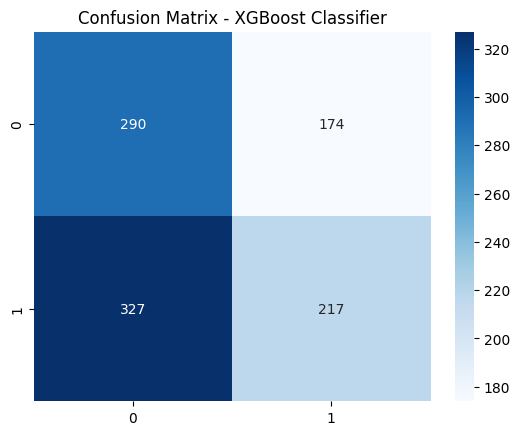

XGBoost Classifier - Train Set
              precision    recall  f1-score   support

           0       0.74      0.69      0.71      1578
           1       0.73      0.77      0.75      1687

    accuracy                           0.73      3265
   macro avg       0.73      0.73      0.73      3265
weighted avg       0.73      0.73      0.73      3265



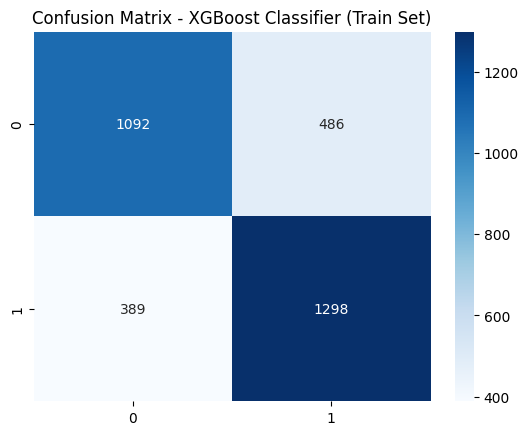

F1-Score Train XGBoost: 0.7479
F1-Score Validation XGBoost: 0.4642
ROC AUC Train XGBoost: 0.7307
ROC AUC Validation XGBoost: 0.5119
F1-Macro-Score Train XGBoost: 0.7309
F1-Macro-Score Validation XGBoost: 0.5004


In [86]:
# Ver metricas del validation set
y_val_pred_xgb = best_xgb.predict(X_val)
print("XGBoost Classifier - Validation Set")
print(classification_report(y_val, y_val_pred_xgb))
cm_xgb = confusion_matrix(y_val, y_val_pred_xgb)
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - XGBoost Classifier")
plt.show()

# Ver metricas del train set
y_train_pred_xgb = best_xgb.predict(X_train)
print("XGBoost Classifier - Train Set")
print(classification_report(y_train, y_train_pred_xgb))
cm_train_xgb = confusion_matrix(y_train, y_train_pred_xgb)
sns.heatmap(cm_train_xgb, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - XGBoost Classifier (Train Set)")
plt.show()

# f1-score, roc_auc, f1-score-macro
f1_train_xgb = f1_score(y_train, y_train_pred_xgb)
f1_val_xgb = f1_score(y_val, y_val_pred_xgb)
roc_auc_train_xgb = roc_auc_score(y_train, y_train_pred_xgb)
roc_auc_val_xgb = roc_auc_score(y_val, y_val_pred_xgb)
f1_macro_train_xgb = f1_score(y_train, y_train_pred_xgb, average='macro')
f1_macro_val_xgb = f1_score(y_val, y_val_pred_xgb, average='macro')
print(f"F1-Score Train XGBoost: {f1_train_xgb:.4f}")
print(f"F1-Score Validation XGBoost: {f1_val_xgb:.4f}")
print(f"ROC AUC Train XGBoost: {roc_auc_train_xgb:.4f}")
print(f"ROC AUC Validation XGBoost: {roc_auc_val_xgb:.4f}")
print(f"F1-Macro-Score Train XGBoost: {f1_macro_train_xgb:.4f}")
print(f"F1-Macro-Score Validation XGBoost: {f1_macro_val_xgb:.4f}")

### 7.4.3 CatBoost

In [73]:
# catboost classifier
from catboost import CatBoostClassifier

# Catboost no necesita mucha preprocesamiento no se usara el preprocessor
# marcar variables categóricas
categorical_indices = [X_train.columns.get_loc(col) for col in categorical_features]
# Create pipeline completo
pipeline_cb = Pipeline(steps=[('classifier', CatBoostClassifier(cat_features=categorical_indices, verbose=0))])

param_grid_cb = {
    'classifier__iterations': [100, 300, 500],
    'classifier__learning_rate': [0.01, 0.1, 0.2],
    'classifier__depth': [4, 6, 8],
    'classifier__l2_leaf_reg': [1, 3, 5, 7],
}

print("Buscando mejores hiperparametros para CatBoost")
grid_search_cb = GridSearchCV(pipeline_cb, param_grid_cb, cv=tscv, scoring='roc_auc', n_jobs=-1)
grid_search_cb.fit(X_train, y_train)
best_cb = grid_search_cb.best_estimator_
y_val_pred_cb = best_cb.predict(X_val)
print("Mejores hiperparametros CatBoost:", grid_search_cb.best_params_)
hiperparams_cb = grid_search_cb.best_params_


Buscando mejores hiperparametros para CatBoost
Mejores hiperparametros CatBoost: {'classifier__depth': 6, 'classifier__iterations': 500, 'classifier__l2_leaf_reg': 7, 'classifier__learning_rate': 0.01}


CatBoost Classifier - Validation Set
              precision    recall  f1-score   support

           0       0.47      0.46      0.46       464
           1       0.55      0.55      0.55       544

    accuracy                           0.51      1008
   macro avg       0.51      0.51      0.51      1008
weighted avg       0.51      0.51      0.51      1008



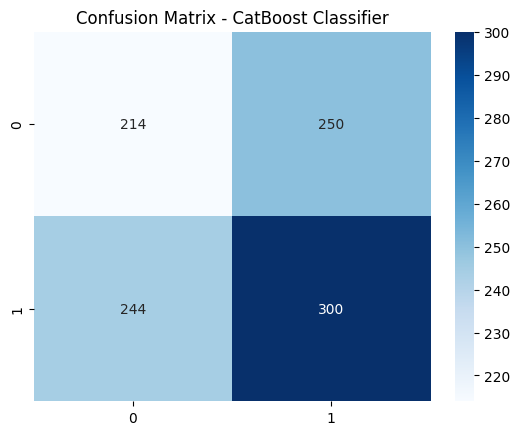

CatBoost Classifier - Train Set
              precision    recall  f1-score   support

           0       0.72      0.78      0.75      1578
           1       0.78      0.71      0.74      1687

    accuracy                           0.75      3265
   macro avg       0.75      0.75      0.75      3265
weighted avg       0.75      0.75      0.75      3265



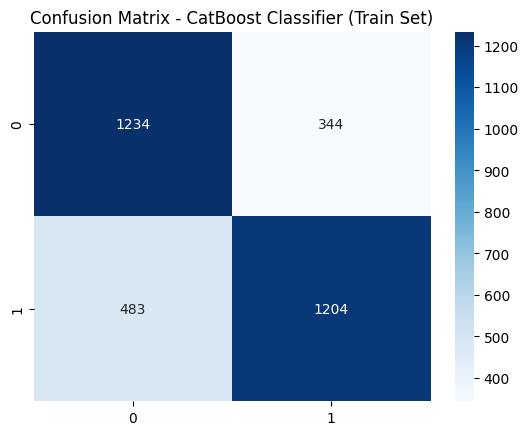

F1-Score Train CatBoost: 0.7467
F1-Score Validation CatBoost: 0.5063
ROC AUC Train CatBoost: 0.7478
ROC AUC Validation CatBoost: 0.5063
F1-Macro-Score Train CatBoost: 0.7467
F1-Macro-Score Validation CatBoost: 0.5063


In [74]:

# Ver metricas del validation set
print("CatBoost Classifier - Validation Set")
print(classification_report(y_val, y_val_pred_cb))
cm_cb = confusion_matrix(y_val, y_val_pred_cb)
sns.heatmap(cm_cb, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - CatBoost Classifier")
plt.show()

# Ver metricas del train set
y_train_pred_cb = best_cb.predict(X_train)
print("CatBoost Classifier - Train Set")
print(classification_report(y_train, y_train_pred_cb))
cm_train_cb = confusion_matrix(y_train, y_train_pred_cb)
sns.heatmap(cm_train_cb, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - CatBoost Classifier (Train Set)")
plt.show()

# f1-score, roc_auc, f1-score-macro
f1_train_cb = f1_score(y_train, y_train_pred_cb, average='macro')
f1_val_cb = f1_score(y_val, y_val_pred_cb, average='macro')
roc_auc_score_train_cb = roc_auc_score(y_train, y_train_pred_cb)
roc_auc_score_val_cb = roc_auc_score(y_val, y_val_pred_cb)
f1_macro_train_cb = f1_score(y_train, y_train_pred_cb, average='macro')
f1_macro_val_cb = f1_score(y_val, y_val_pred_cb, average='macro')
print(f"F1-Score Train CatBoost: {f1_train_cb:.4f}")
print(f"F1-Score Validation CatBoost: {f1_val_cb:.4f}")
print(f"ROC AUC Train CatBoost: {roc_auc_score_train_cb:.4f}")
print(f"ROC AUC Validation CatBoost: {roc_auc_score_val_cb:.4f}")
print(f"F1-Macro-Score Train CatBoost: {f1_macro_train_cb:.4f}")
print(f"F1-Macro-Score Validation CatBoost: {f1_macro_val_cb:.4f}")

# 8. Evaluación

In [87]:
# comparacion tabular de los 7 modelos
results = pd.DataFrame({
    'Model': ['Baseline', 'Logistic Regression', 'Decision Tree', 'Random Forest', 'Extra Trees', 'Gradient Boosting', 'XGBoost', 'CatBoost'],
    'F1-Score Train': [f1_train_baseline, f1_train_logreg, f1_train_dt, f1_train_rf, f1_train_et, f1_train_gb, f1_train_xgb, f1_train_cb],
    'F1-Score Validation': [f1_val_baseline, f1_val_logreg, f1_val_dt, f1_val_rf, f1_val_et, f1_val_gb, f1_val_xgb, f1_val_cb],
    'ROC-AUC Train': [roc_auc_train_baseline, roc_auc_train_logreg, roc_auc_train_dt, roc_auc_train_rf, roc_auc_train_et, roc_auc_train_gb, roc_auc_train_xgb, roc_auc_score_train_cb],
    'ROC-AUC Validation': [roc_auc_val_baseline, roc_auc_val_logreg, roc_auc_val_dt, roc_auc_val_rf, roc_auc_val_et, roc_auc_val_gb, roc_auc_val_xgb, roc_auc_score_val_cb],
    'F1-Macro Train': [f1_macro_train_baseline, f1_macro_train_logreg, f1_macro_train_dt, f1_macro_train_rf, f1_macro_train_et, f1_macro_train_gb, f1_macro_train_xgb, f1_macro_train_cb],
    'F1-Macro Validation': [f1_macro_val_baseline, f1_macro_val_logreg, f1_macro_val_dt, f1_macro_val_rf, f1_macro_val_et, f1_macro_val_gb, f1_macro_val_xgb, f1_macro_val_cb]
})
print(results)

                 Model  F1-Score Train  F1-Score Validation  ROC-AUC Train  \
0             Baseline        0.681341             0.701031       0.500000   
1  Logistic Regression        0.625313             0.577624       0.584720   
2        Decision Tree        0.627287             0.526116       0.646665   
3        Random Forest        0.726703             0.603313       0.674290   
4          Extra Trees        0.785863             0.525926       0.778998   
5    Gradient Boosting        0.714119             0.404230       0.698959   
6              XGBoost        0.747911             0.464171       0.730714   
7             CatBoost        0.746686             0.506327       0.747848   

   ROC-AUC Validation  F1-Macro Train  F1-Macro Validation  
0            0.500000        0.340670             0.350515  
1            0.508652        0.583185             0.506657  
2            0.504596        0.643658             0.503972  
3            0.541075        0.669391             0.5

In [77]:
# Escoger el mejor modelo
best_model_name = results.loc[results['ROC-AUC Validation'].idxmax(), 'Model']
print(f"Mejor modelo en validación: {best_model_name}")

if best_model_name == 'Baseline':
    print("Los modelos no superaron al baseline")
if best_model_name == 'Logistic Regression':
    best_model = best_logreg
elif best_model_name == 'Decision Tree':
    best_model = best_dt
elif best_model_name == 'Random Forest':
    best_model = best_rf
elif best_model_name == 'Extra Trees':
    best_model = best_et
elif best_model_name == 'Gradient Boosting':
    best_model = best_gb
elif best_model_name == 'XGBoost':
    best_model = best_xgb
elif best_model_name == 'CatBoost':
    best_model = best_cb

# Reentrenar el mejor modelo con train + validation
X_train_val = pd.concat([X_train, X_val])
y_train_val = pd.concat([y_train, y_val])
best_model.fit(X_train_val, y_train_val)

Mejor modelo en validación: Random Forest


,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


## 8.1 Justificación del modelo

ROC-AUC (Receiver Operating Characteristic – Area Under Curve) mide la capacidad de un modelo para discriminar entre clases.

- Mejor capacidad de discriminación: Random Forest separa mejor las clases que otros modelos (mayor ROC-AUC).

- Menos sobreajuste que modelos con F1 muy alto en train: Modelos como Extra Trees o XGBoost muestran F1 alta en train pero baja en validación, lo que indica sobreajuste.

- Generalización sobre validación: ROC-AUC de validación refleja rendimiento en datos no vistos, crucial para producción.

Por eso, a pesar de que otros modelos puedan tener F1-Score de train más alto, se priorizó Random Forest por su mejor ROC-AUC en validación, buscando un equilibrio entre discriminación y generalización.

# 9. Simulación

Random Forest - Test Set
              precision    recall  f1-score   support

           0       0.49      0.23      0.31       430
           1       0.53      0.79      0.64       482

    accuracy                           0.52       912
   macro avg       0.51      0.51      0.47       912
weighted avg       0.51      0.52      0.48       912



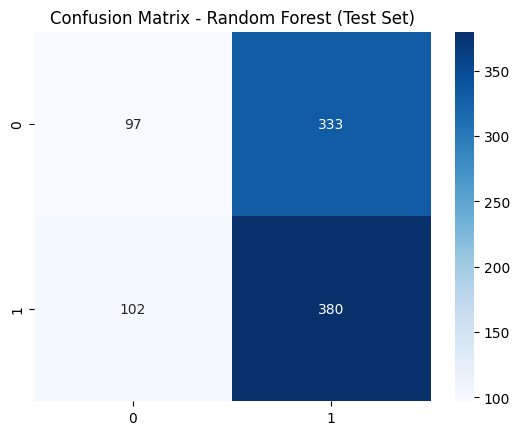

F1-Score Test Random Forest: 0.6360
ROC AUC Test Random Forest: 0.5070
F1-Macro-Score Test Random Forest: 0.4722


In [91]:
df_sim = test_df.copy() # crear copia del test para simulacion
X_test_sim = df_sim[feature_cols]
y_test_sim = df_sim[target_col]

df_sim['Prediction'] = best_model.predict(X_test_sim)

# Evaluar en el test set
y_test_pred = df_sim['Prediction']
print(f"{best_model_name} - Test Set")
print(classification_report(y_test_sim, y_test_pred))
cm_test = confusion_matrix(y_test_sim, y_test_pred)
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues')
plt.title(f"Confusion Matrix - {best_model_name} (Test Set)")
plt.show()

# f1-score, roc_auc, f1-score-macro
f1_test = f1_score(y_test_sim, y_test_pred)
roc_auc_test = roc_auc_score(y_test_sim, y_test_pred)
f1_macro_test = f1_score(y_test_sim, y_test_pred, average='macro')
print(f"F1-Score Test {best_model_name}: {f1_test:.4f}")
print(f"ROC AUC Test {best_model_name}: {roc_auc_test:.4f}")
print(f"F1-Macro-Score Test {best_model_name}: {f1_macro_test:.4f}")

/tmp/ipykernel_262/4077439825.py:16: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '9979.905454955942' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_t.loc[df_t.index[i], "Capital"] = prev_cap * (1 + ret)
/tmp/ipykernel_262/4077439825.py:16: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '10180.274325615157' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_t.loc[df_t.index[i], "Capital"] = prev_cap * (1 + ret)
/tmp/ipykernel_262/4077439825.py:16: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '10124.584316190669' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_t.loc[df_t.index[i], "Capital"] = prev_cap * (1 + ret)
/t

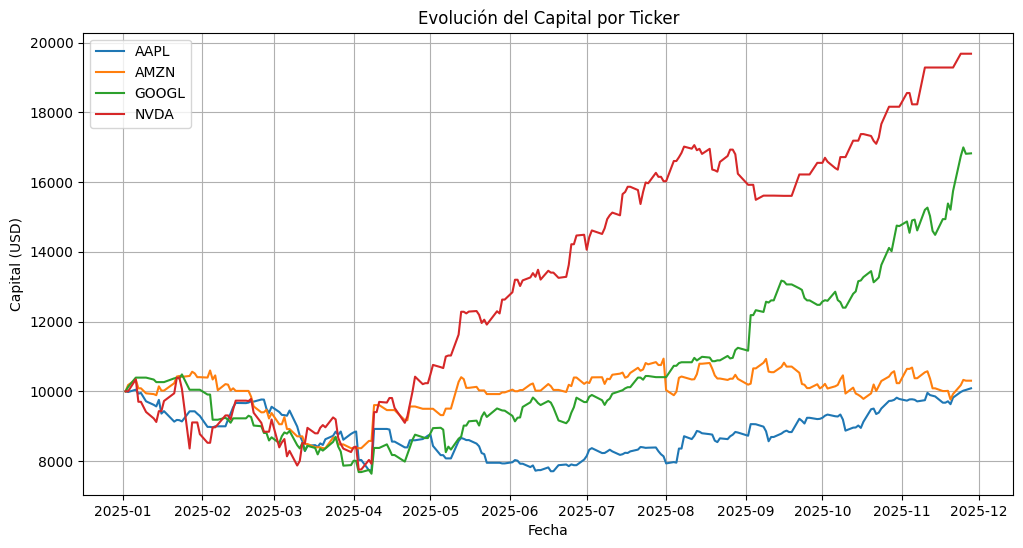

AAPL: capital final = $10,086.26
AMZN: capital final = $10,304.61
GOOGL: capital final = $16,826.35
NVDA: capital final = $19,684.85


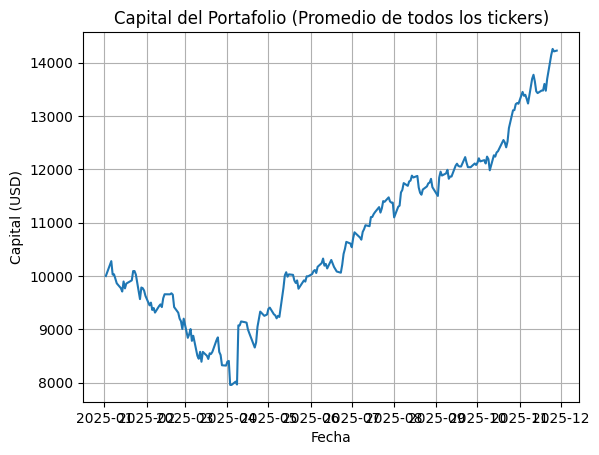

Capital final del portafolio: $14,225.52


In [92]:
df_sim = df_sim.sort_values(["ticker", "date"]).copy()

capital_inicial = 10000

resultados = {}
for ticker, df_t in df_sim.groupby("ticker"):
    
    df_t = df_t.copy()
    df_t["Capital"] = capital_inicial

    for i in range(1, len(df_t)):
        prev_cap = df_t.iloc[i-1]["Capital"]

        if df_t.iloc[i]["Prediction"] == 1:  # Señal BUY
            ret = (df_t.iloc[i]["close"] - df_t.iloc[i-1]["close"]) / df_t.iloc[i-1]["close"]
            df_t.loc[df_t.index[i], "Capital"] = prev_cap * (1 + ret)
        else:
            df_t.loc[df_t.index[i], "Capital"] = prev_cap

    resultados[ticker] = df_t

plt.figure(figsize=(12,6))

for ticker, df_t in resultados.items():
    plt.plot(df_t["date"], df_t["Capital"], label=ticker)

plt.title("Evolución del Capital por Ticker")
plt.xlabel("Fecha")
plt.ylabel("Capital (USD)")
plt.grid()
plt.legend()
plt.show()

for ticker, df_t in resultados.items():
    capital_final = df_t["Capital"].iloc[-1]
    print(f"{ticker}: capital final = ${capital_final:,.2f}")

df_portfolio = pd.concat(resultados.values()).sort_values(["date","ticker"])

df_portfolio = df_portfolio.groupby("date")["Capital"].mean()  # ejemplo: promedio del capital por día

plt.plot(df_portfolio.index, df_portfolio.values)
plt.title("Capital del Portafolio (Promedio de todos los tickers)")
plt.xlabel("Fecha")
plt.ylabel("Capital (USD)")
plt.grid()
plt.show()

print(f"Capital final del portafolio: ${df_portfolio.values[-1]:,.2f}")

# 10. Guardar el mejor modelo para prediccion

In [96]:
import joblib

MODEL_PATH = "../model.joblib"

joblib.dump(best_model, "/home/jovyan/work/model.joblib")
print("Modelo guardado en model.joblib")

Modelo guardado en model.joblib
